#  Capstone Project - The Battle of Neighborhoods (Week 1)

Clearly define a problem or an idea of your choice, where you would need to leverage the Foursquare location data to solve or execute. Remember that data science problems always target an audience and are meant to help a group of stakeholders solve a problem, so make sure that you explicitly describe your audience and why they would care about your problem.

## Introduction: Business Problem 

This project aims to cluster areas in Gauteng using **k-means** clustering. These cluster will make use of data on **total crimes in each area** and the **10 most common venues** in each neighborhood. Once we have segmented the neighborhoods, we will analyse the top 5 safest areas and examine the 10 most common attractions nearby.
This report will be targeted at people who are looking to relocate to Gauteng, South Africa. In South Africa, safety is considered as a top concern when moving to a new place. If you don’t feel safe in your own home, you’re not going to be able to enjoy living there. The crime statistics will provide an insight into this issue.
We will focus on the areas in Gauteng and explore its neighborhoods and the 10 most common venues in each neighborhood so that the best neighborhood suited to an individual's needs can be selected. A suitable choice will be one that has a combination of safety and attraction. 


## Data 

Based on the definition of our problem, factors that will influence our decision are:
The total number of crimes commited in each of the areas during the lastest year available and 
the most common venues in each of the neighborhoods in Gauteng.

Following data sources will be needed to extract/generate the required information:

- **Part 1:** Preprocessing a real world data set from Kaggle showing the South African Crimes from 2005 to 2016: A dataset consisting of the crime statistics of each Ploice Station in South Africa is obtained from Kaggle. 

- **Part 2:** Creating a new dataset of the Neighborhoods of the areas in Gauteng and generating their co-ordinates.: Co-ordinate of neighborhoods will be obtained using Google Maps API geocoding



#### Part 1: Preprocessing a real world data set from Kaggle showing the South African Crimes from 2005 to 2016

About this file

- Province: The Province name in South Africa
- Station: The name of the Police Station that the crime is being reported to.
- Category: The type of crime being reported
- 2005 -2016: Years with reported crime counts

Data set URL: https://www.kaggle.com/slwessels/crime-statistics-for-south-africa

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
from bs4 import BeautifulSoup # library for web scrapping  

#!conda install -c conda-forge geocoder --yes
import geocoder

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


### Define Foursquare Credentials and Version
Make sure that you have created a Foursquare developer account and have your credentials handy

In [2]:
CLIENT_ID = 'R01LINGO2WC45KLRLKT3ZHU2QENAO2IPRK2N2ELOHRNK4P3K' # your Foursquare ID
CLIENT_SECRET = '4JT1TWRMXMPLX5IOKNBAFU3L3ARXK4D5JJDPFK1CLRZM2ZVW' # your Foursquare Secret

VERSION = '20180604'
LIMIT = 30

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: R01LINGO2WC45KLRLKT3ZHU2QENAO2IPRK2N2ELOHRNK4P3K
CLIENT_SECRET:4JT1TWRMXMPLX5IOKNBAFU3L3ARXK4D5JJDPFK1CLRZM2ZVW


Now we read in the Data that we have downloaded from Kaggle

In [3]:
df = pd.read_csv("/Users/lukabeverin/Downloads/SouthAfricaCrimeStats_v2.csv")

In [4]:
df.head()

,Province,Station,Category,2005-2006,2006-2007,2007-2008,2008-2009,2009-2010,2010-2011,2011-2012,2012-2013,2013-2014,2014-2015,2015-2016
0,Western Cape,Cape Town Central,All theft not mentioned elsewhere,6692,6341,5966,5187,4985,5127,5285,5937,5600,5335,5176
1,Gauteng,Jhb Central,All theft not mentioned elsewhere,6093,4602,3761,3610,3267,3037,2886,2638,2809,3050,2434
2,Western Cape,Mitchells Plain,All theft not mentioned elsewhere,5341,6093,6316,6803,6035,5761,6108,5514,4975,4043,3635
3,Free State,Park Road,All theft not mentioned elsewhere,5108,4282,3834,3316,3101,3013,2679,3116,2927,2297,2103
4,Gauteng,Pretoria Central,All theft not mentioned elsewhere,5099,4536,3309,2694,2616,2606,2635,3226,3246,2892,3030


We are only interested in the last year available so only retain the latest year **2015-2016**. This is done by dropping columns specified by their column number. Remember that the index starts at 0, so column 1 = 0 etc.

In [5]:
df = df.drop(df.columns[[3,4,5,6,7,8,9,10,11,12]], axis=1)
df.head()

,Province,Station,Category,2015-2016
0,Western Cape,Cape Town Central,All theft not mentioned elsewhere,5176
1,Gauteng,Jhb Central,All theft not mentioned elsewhere,2434
2,Western Cape,Mitchells Plain,All theft not mentioned elsewhere,3635
3,Free State,Park Road,All theft not mentioned elsewhere,2103
4,Gauteng,Pretoria Central,All theft not mentioned elsewhere,3030


Delete all Nan rows

In [6]:
df = df.dropna()
df = df.reset_index(drop=True)

In [7]:
df.shape

(30861, 4)

View the information of the dataset 

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30861 entries, 0 to 30860
Data columns (total 4 columns):
Province     30861 non-null object
Station      30861 non-null object
Category     30861 non-null object
2015-2016    30861 non-null int64
dtypes: int64(1), object(3)
memory usage: 964.5+ KB


See the different types of crimes reported and their counts.

In [9]:
df['Category'].value_counts()

Carjacking                                                 1143
Assault with the intent to inflict grievous bodily harm    1143
Burglary at residential premises                           1143
Murder                                                     1143
Attempted murder                                           1143
Malicious damage to property                               1143
Truck hijacking                                            1143
Robbery of cash in transit                                 1143
Burglary at non-residential premises                       1143
Illegal possession of firearms and ammunition              1143
Sexual offences as result of police action                 1143
Shoplifting                                                1143
Arson                                                      1143
Drug-related crime                                         1143
Theft out of or from motor vehicle                         1143
Sexual Offences                         

For this project, we are only interested in the **Gauteng Province**. 

In [10]:
df = df.loc[df['Province'] == 'Gauteng']
df.head()

,Province,Station,Category,2015-2016
1,Gauteng,Jhb Central,All theft not mentioned elsewhere,2434
4,Gauteng,Pretoria Central,All theft not mentioned elsewhere,3030
7,Gauteng,Brooklyn,All theft not mentioned elsewhere,2107
8,Gauteng,Booysens,All theft not mentioned elsewhere,943
9,Gauteng,Hillbrow,All theft not mentioned elsewhere,1618


Now that we have a dataframe for the year **2015-2016** and **Gauteng Province**, let's change the last column name to 'No_of_crimes' in order to simplify the dataset.

In [11]:
df.columns = ['Province', 'Station','Category','No_of_Crimes']
df.head()

,Province,Station,Category,No_of_Crimes
1,Gauteng,Jhb Central,All theft not mentioned elsewhere,2434
4,Gauteng,Pretoria Central,All theft not mentioned elsewhere,3030
7,Gauteng,Brooklyn,All theft not mentioned elsewhere,2107
8,Gauteng,Booysens,All theft not mentioned elsewhere,943
9,Gauteng,Hillbrow,All theft not mentioned elsewhere,1618


Let's have a look at all the **unique** Police stations.

In [12]:
df['Station'].unique()

array(['Jhb Central', 'Pretoria Central', 'Brooklyn', 'Booysens',
       'Hillbrow', 'Sandton', 'Sunnyside', 'Lyttelton', 'Honeydew',
       'Kempton Park', 'Krugersdorp', 'Roodepoort', 'Vanderbijlpark',
       'Pretoria West', 'Mamelodi', 'Garsfontein', 'Katlehong',
       'Douglasdale', 'Moroka', 'Boksburg North', 'Or Tambo Intern Airp',
       'Benoni', 'Linden', 'Wierdabrug', 'Brixton', 'Florida',
       'Randfontein', 'Randburg', 'Alberton', 'Vereeniging', 'Tembisa',
       'Mondeor', 'Silverton', 'Midrand', 'Sophia Town', 'Sinoville',
       'Germiston', 'Springs', 'Jeppe', 'Alexandra', 'Akasia',
       'Pretoria North', 'Brakpan', 'Norwood', 'Bedfordview', 'Temba',
       'Meadowlands', 'Atteridgeville', 'Lenasia', 'Bramley',
       'Carletonville', 'Cleveland', 'Hercules', 'Westonaria',
       'Ivory Park', 'Rietgat', 'Evaton', 'Parkview', 'Dobsonville',
       'Kagiso', 'Edenvale', 'Kliptown', 'Villieria', 'Norkempark',
       'Orlando', 'Vosloorus', 'Diepkloof', 'Soshanguve',

There are **143** different areas/stations in **Gauteng**.

Let's examine the different categories of crimes.

In [13]:
df['Category'].unique()

array(['All theft not mentioned elsewhere', 'Commercial crime',
       'Robbery with aggravating circumstances',
       'Theft out of or from motor vehicle',
       'Assault with the intent to inflict grievous bodily harm',
       'Burglary at residential premises', 'Common assault',
       'Theft of motor vehicle and motorcycle', 'Shoplifting',
       'Common robbery', 'Malicious damage to property',
       'Drug-related crime', 'Burglary at non-residential premises',
       'Driving under the influence of alcohol or drugs', 'Carjacking',
       'Sexual Offences', 'Robbery at non-residential premises',
       'Robbery at residential premises', 'Attempted murder',
       'Illegal possession of firearms and ammunition', 'Murder', 'Arson',
       'Stock-theft', 'Truck hijacking', 'Robbery of cash in transit',
       'Bank robbery', 'Sexual offences as result of police action'],
      dtype=object)

In [14]:
df['Category'].value_counts()

Malicious damage to property                               143
Shoplifting                                                143
Common assault                                             143
Robbery at residential premises                            143
Sexual Offences                                            143
Robbery of cash in transit                                 143
Driving under the influence of alcohol or drugs            143
All theft not mentioned elsewhere                          143
Robbery at non-residential premises                        143
Burglary at non-residential premises                       143
Commercial crime                                           143
Sexual offences as result of police action                 143
Common robbery                                             143
Burglary at residential premises                           143
Attempted murder                                           143
Theft of motor vehicle and motorcycle                  

Now we pivot the table to view the no. of crimes for each category of crime reported at each Police station in Gauteng

In [15]:
Gauteng_crime = pd.pivot_table(df,values=['No_of_Crimes'],
                               index=['Station'],
                               columns=['Category'],
                               aggfunc=np.sum,fill_value=0)
Gauteng_crime.head()

No_of_Crimes        \
Category       All theft not mentioned elsewhere Arson   
Station                                                  
Actonville                                   185    10   
Akasia                                      1692    15   
Alberton                                    1103     5   
Alexandra                                    758     8   
Atteridgeville                              1061    21   

                                                                        \
Category       Assault with the intent to inflict grievous bodily harm   
Station                                                                  
Actonville                                                    261        
Akasia                                                        300        
Alberton                                                      225        
Alexandra                                                     756        
Atteridgeville                                                387        

                                              \
Category       Attempted murder Bank robbery   
Station                                        
Actonville                   21            0   
Akasia                       30            0   
Alberton                     27            0   
Alexandra                    84            0   
Atteridgeville               92            0   

                                                     \
Category       Burglary at non-residential premises   
Station                                               
Actonville                                       18   
Akasia                                          148   
Alberton                                        221   
Alexandra                                       121   
Atteridgeville                                   99   

                                                                             \
Category       Burglary at residential premises Carjacking Commercial crime   
Station                                                                       
Actonville                                  114         24               33   
Akasia                                      906        102              268   
Alberton                                    602         78              414   
Alexandra                                   504        106              135   
Atteridgeville                              745         89               85   

                               ...                                  \
Category       Common assault  ... Robbery at residential premises   
Station                        ...                                   
Actonville                135  ...                              14   
Akasia                    477  ...                              93   
Alberton                  313  ...                              73   
Alexandra                 809  ...                              47   
Atteridgeville            601  ...                              66   

                                           \
Category       Robbery of cash in transit   
Station                                     
Actonville                              1   
Akasia                                  0   
Alberton                                2   
Alexandra                               1   
Atteridgeville                          0   

                                                                       \
Category       Robbery with aggravating circumstances Sexual Offences   
Station                                                                 
Actonville                                        126              31   
Akasia                                            620             124   
Alberton                                          457              60   
Alexandra                                         649             179   
Atteridgeville                                    616             117   

            

Reset the index

In [16]:
Gauteng_crime.reset_index(inplace = True)

Here we calculate the total crimes for each Station in Gauteng (create a new column at the end of the table called 'Total').

In [17]:
Gauteng_crime['Total'] = Gauteng_crime.sum(axis=1)
Gauteng_crime.head(10)

Station                      No_of_Crimes        \
Category                 All theft not mentioned elsewhere Arson   
0             Actonville                               185    10   
1                 Akasia                              1692    15   
2               Alberton                              1103     5   
3              Alexandra                               758     8   
4         Atteridgeville                              1061    21   
5            Bedfordview                               822     5   
6             Bekkersdal                               252     6   
7                 Benoni                              1114    13   
8              Boipatong                                76     0   
9               Boksburg                               605    11   

                                                                  \
Category Assault with the intent to inflict grievous bodily harm   
0                                                       261        
1                                                       300        
2                                                       225        
3                                                       756        
4                                                       387        
5                                                        46        
6                                                       269        
7                                                       330        
8                                                       125        
9                                                       180        

                                                                             \
Category Attempted murder Bank robbery Burglary at non-residential premises   
0                      21            0                                   18   
1                      30            0                                  148   
2                      27            0                                  221   
3                      84            0                                  121   
4                      92            0                                   99   
5                      17            0                                  134   
6                      35            0                                   80   
7                      53            0                                  375   
8                       2            0                                   13   
9                      30            0                                  117   

                                                                       ...  \
Category Burglary at residential premises Carjacking Commercial crime  ...   
0                                     114         24               33  ...   
1                                     906        102              268  ...   
2                                     602         78              414  ...   
3                                     504        106              135  ...   
4                                     745         89               85  ...   
5                                     145         35              254  ...   
6                                     277         50               10  ...   
7                                     690         71              492  ...   
8                                      65          4                4  ...   
9                                     547         37              212  ...   

                                                                            \
Category Robbery of cash in transit Robbery with aggravating circumstances   
0                                 1                                    126   
1                                 0                                    620   
2                                 2                                    457   
3                                 1                                    649   
4                            

Simple Bar plot of the total number of crimes per station

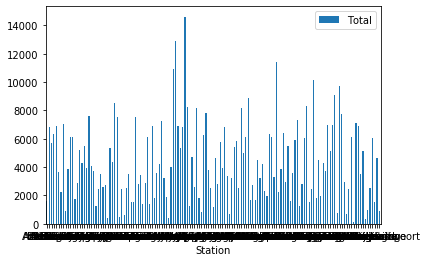

In [35]:
 ax = Gauteng_crime.plot.bar(x='Station', y='Total', rot=0)

Let's visualise the top 5 most dangerous Police stations

In [36]:
#sort values by total
Gauteng_crime.sort_values(['Total'], ascending = False, axis = 0, inplace = True )

df_top5 = Gauteng_crime.head() 
df_top5

,Station,All theft not mentioned elsewhere,Commercial crime,Robbery with aggravating circumstances,Theft out of or from motor vehicle,Assault with the intent to inflict grievous bodily harm,Burglary at residential premises,Common assault,Theft of motor vehicle and motorcycle,Shoplifting,...,Attempted murder,Illegal possession of firearms and ammunition,Murder,Arson,Stock-theft,Truck hijacking,Robbery of cash in transit,Bank robbery,Sexual offences as result of police action,Total
59,Jhb Central,2434,4,680,70,0,487,71,131,1137,...,0,1694,138,1,1372,0,406,1471,2,14607
55,Honeydew,2346,13,676,97,0,281,1530,98,584,...,0,1076,153,6,466,1,835,1104,4,12889
98,Pretoria Central,3030,11,461,21,0,235,109,46,466,...,0,763,94,1,68,0,409,1376,2,11444
54,Hillbrow,1618,6,1069,79,0,150,120,86,624,...,1,1187,141,2,328,0,434,1222,0,10933
114,Sandton,2866,1,173,10,0,214,758,76,879,...,1,766,51,52,410,3,340,1282,6,10131


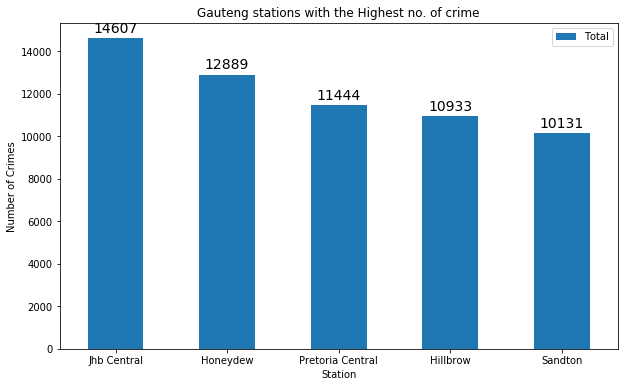

In [38]:
df_tt = df_top5[['Station','Total']]

df_tt.set_index('Station',inplace = True)

ax = df_tt.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Station') # add y-label to the plot
ax.set_title('Gauteng stations with the Highest no. of crime') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

The most dangerous areas are located around Jhb Central, Honeydew, Pretoria Central, Hillbrow and Sandton. Let's **avoid** these areas.

Let's qucikly analyse the area with the highest number of total crimes.

In [19]:
print (Gauteng_crime.loc[Gauteng_crime['Total'].idxmax()])

              Category                                               
Station                                                                  Jhb Central
No_of_Crimes  All theft not mentioned elsewhere                                 2434
              Arson                                                                4
              Assault with the intent to inflict grievous bodily harm            680
              Attempted murder                                                    70
              Bank robbery                                                         0
              Burglary at non-residential premises                               487
              Burglary at residential premises                                    71
              Carjacking                                                         131
              Commercial crime                                                  1137
              Common assault                                                    

The station with the highest total crimes is **Jhb Central** with a total of **14 607 crimes** reported in the year 2015-2016.

Next in the data cleaning phase we remove the multi index so that it will be easier to merge tables

In [20]:
Gauteng_crime.columns = Gauteng_crime.columns.map(''.join)
Gauteng_crime.head()

,Station,No_of_CrimesAll theft not mentioned elsewhere,No_of_CrimesArson,No_of_CrimesAssault with the intent to inflict grievous bodily harm,No_of_CrimesAttempted murder,No_of_CrimesBank robbery,No_of_CrimesBurglary at non-residential premises,No_of_CrimesBurglary at residential premises,No_of_CrimesCarjacking,No_of_CrimesCommercial crime,...,No_of_CrimesRobbery of cash in transit,No_of_CrimesRobbery with aggravating circumstances,No_of_CrimesSexual Offences,No_of_CrimesSexual offences as result of police action,No_of_CrimesShoplifting,No_of_CrimesStock-theft,No_of_CrimesTheft of motor vehicle and motorcycle,No_of_CrimesTheft out of or from motor vehicle,No_of_CrimesTruck hijacking,Total
0,Actonville,185,10,261,21,0,18,114,24,33,...,1,126,31,2,47,0,64,69,0,1583
1,Akasia,1692,15,300,30,0,148,906,102,268,...,0,620,124,1,268,5,319,373,0,6828
2,Alberton,1103,5,225,27,0,221,602,78,414,...,2,457,60,3,287,0,478,363,26,5721
3,Alexandra,758,8,756,84,0,121,504,106,135,...,1,649,179,2,169,0,148,188,1,6326
4,Atteridgeville,1061,21,387,92,0,99,745,89,85,...,0,616,117,0,203,0,92,336,8,6888


Renaming the columns (we get the array of col names from df['Category'].unique())

In [21]:
Gauteng_crime.columns = ['Station','All theft not mentioned elsewhere', 'Commercial crime',
       'Robbery with aggravating circumstances',
       'Theft out of or from motor vehicle',
       'Assault with the intent to inflict grievous bodily harm',
       'Burglary at residential premises', 'Common assault',
       'Theft of motor vehicle and motorcycle', 'Shoplifting',
       'Common robbery', 'Malicious damage to property',
       'Drug-related crime', 'Burglary at non-residential premises',
       'Driving under the influence of alcohol or drugs', 'Carjacking',
       'Sexual Offences', 'Robbery at non-residential premises',
       'Robbery at residential premises', 'Attempted murder',
       'Illegal possession of firearms and ammunition', 'Murder', 'Arson',
       'Stock-theft', 'Truck hijacking', 'Robbery of cash in transit',
       'Bank robbery', 'Sexual offences as result of police action','Total']
Gauteng_crime.head()

,Station,All theft not mentioned elsewhere,Commercial crime,Robbery with aggravating circumstances,Theft out of or from motor vehicle,Assault with the intent to inflict grievous bodily harm,Burglary at residential premises,Common assault,Theft of motor vehicle and motorcycle,Shoplifting,...,Attempted murder,Illegal possession of firearms and ammunition,Murder,Arson,Stock-theft,Truck hijacking,Robbery of cash in transit,Bank robbery,Sexual offences as result of police action,Total
0,Actonville,185,10,261,21,0,18,114,24,33,...,1,126,31,2,47,0,64,69,0,1583
1,Akasia,1692,15,300,30,0,148,906,102,268,...,0,620,124,1,268,5,319,373,0,6828
2,Alberton,1103,5,225,27,0,221,602,78,414,...,2,457,60,3,287,0,478,363,26,5721
3,Alexandra,758,8,756,84,0,121,504,106,135,...,1,649,179,2,169,0,148,188,1,6326
4,Atteridgeville,1061,21,387,92,0,99,745,89,85,...,0,616,117,0,203,0,92,336,8,6888


In [99]:
#backwards engineering step, we do this to match the later dbf file of police locations
Gauteng_crime= Gauteng_crime.apply(lambda x: x.astype(str).str.upper())
Gauteng_crime.head()

,Station,All theft not mentioned elsewhere,Commercial crime,Robbery with aggravating circumstances,Theft out of or from motor vehicle,Assault with the intent to inflict grievous bodily harm,Burglary at residential premises,Common assault,Theft of motor vehicle and motorcycle,Shoplifting,...,Attempted murder,Illegal possession of firearms and ammunition,Murder,Arson,Stock-theft,Truck hijacking,Robbery of cash in transit,Bank robbery,Sexual offences as result of police action,Total
59,JHB CENTRAL,2434,4,680,70,0,487,71,131,1137,...,0,1694,138,1,1372,0,406,1471,2,14607
55,HONEYDEW,2346,13,676,97,0,281,1530,98,584,...,0,1076,153,6,466,1,835,1104,4,12889
98,PRETORIA CENTRAL,3030,11,461,21,0,235,109,46,466,...,0,763,94,1,68,0,409,1376,2,11444
54,HILLBROW,1618,6,1069,79,0,150,120,86,624,...,1,1187,141,2,328,0,434,1222,0,10933
114,SANDTON,2866,1,173,10,0,214,758,76,879,...,1,766,51,52,410,3,340,1282,6,10131


**A correlation heatmap of the feautures.**

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

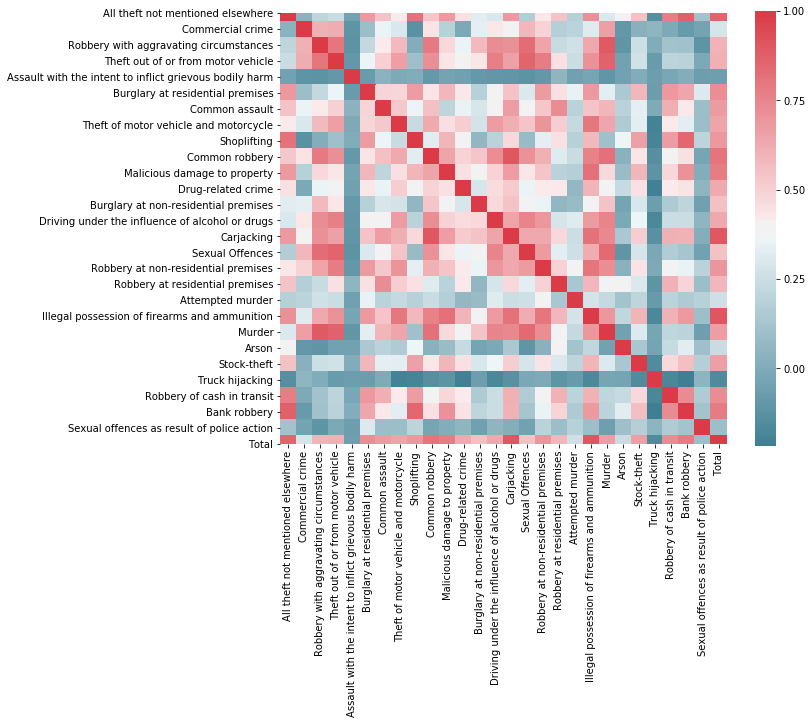

In [27]:
f, ax = plt.subplots(figsize=(10, 8))
corr = Gauteng_crime.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

Next we create a data frame of the different municipalities in Gauteng. This was done manually as the data was all over the place. Data is from Wikipedia. This step is unecessary but helps to visualise the different municipalities. 

In [33]:
#importing pandas as pd 
import pandas as pd 
  
#dictionary of lists 
dict = {'Municipality':["City of Johannesburg", "City of Tshwane", "Ekurhuleni", "Emfuleni","Lesedi","Merafong","Midvaal","Mogale City","Rand West"], 
        'Latitude': [-26.166666666666668,-25.666666666666668,-26.166666666666668,-26.666666666666668,-26.5,-26.416666666666668,-26.583333333333332,-26,-26.174499302], 
        'Longitude':[28,28.333333333333332,28.3,27.75,28.5,27.416666666666668,28.083333333333332,27.666666666666668,27.70249719]} 
  
Gauteng = pd.DataFrame(dict) 
  
print(Gauteng) 

           Municipality   Latitude  Longitude
0  City of Johannesburg -26.166667  28.000000
1       City of Tshwane -25.666667  28.333333
2            Ekurhuleni -26.166667  28.300000
3              Emfuleni -26.666667  27.750000
4                Lesedi -26.500000  28.500000
5              Merafong -26.416667  27.416667
6               Midvaal -26.583333  28.083333
7           Mogale City -26.000000  27.666667
8             Rand West -26.174499  27.702497


**Latitude** and **longitude** of **Gauteng**. These co-ordinates will be used to output maps.

In [39]:
latitude = -26.270760
longitude = 28.112268

Map of the different municipalities in Gauteng.

In [41]:
map_gauteng = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, Municipality in zip(Gauteng['Latitude'], Gauteng['Longitude'], Gauteng['Municipality']):
    label = '{}'.format(Municipality)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_gauteng)  
    
map_gauteng

In [44]:
!pip install geopandas

     |████████████████████████████████| 931kB 774kB/s eta 0:00:01
     |████████████████████████████████| 13.9MB 1.3MB/s eta 0:00:01
     |████████████████████████████████| 1.6MB 1.3MB/s eta 0:00:01
     |████████████████████████████████| 11.0MB 210kB/s eta 0:00:01


#### Import the dbf file which contains the geolocations of the Police stations in South Africa. 

This dataset is also downloaded from Kaggle ()

In [51]:
!pip install dbfread

from dbfread import DBF
table = DBF('/Users/lukabeverin/Downloads/Police_points.dbf')


In [59]:
!pip install simpledbf

  Created wheel for simpledbf: filename=simpledbf-0.2.6-cp37-none-any.whl size=13793 sha256=2674f7f0f6d95a8dce11b11a3c0004ae812d4c512ebab21649cc53b3b7eb01e5
  Stored in directory: /Users/lukabeverin/Library/Caches/pip/wheels/72/dd/df/cdfb970a508ef9750ebb4b6e035a3410c3d62b5a6a91d2aafc
Successfully built simpledbf


In [88]:
from simpledbf import Dbf5

dbf = Dbf5('/Users/lukabeverin/Downloads/Police_points.dbf')
df1 = dbf.to_dataframe()

Output top 5 observations from the table.

In [89]:
df1.head()

,COMPNT_NM,LOCATION_X,LOCATION_Y,CREATE_DT,VERSION
0,BOTSHABELO,26.71606,-29.23620,20151030,1.1.3
1,KHUBUSIDRIFT,27.62384,-32.56819,20151030,1.1.3
2,STUTTERHEIM,27.42741,-32.57118,20151030,1.1.3
3,MOTHERWELL,25.58419,-33.79664,20151030,1.1.3
4,KWADWESI,25.52347,-33.84109,20151030,1.1.3


Rename the columns for clarity.

In [90]:
df1.columns = ['Station','Longitude','Latitude','Create_Date','Version']
df1.head()

,Station,Longitude,Latitude,Create_Date,Version
0,BOTSHABELO,26.71606,-29.23620,20151030,1.1.3
1,KHUBUSIDRIFT,27.62384,-32.56819,20151030,1.1.3
2,STUTTERHEIM,27.42741,-32.57118,20151030,1.1.3
3,MOTHERWELL,25.58419,-33.79664,20151030,1.1.3
4,KWADWESI,25.52347,-33.84109,20151030,1.1.3


Drop cols Create_date and Version

In [91]:
df1 = df1.drop(df1.columns[[3,4]], axis=1)
df1.head()

,Station,Longitude,Latitude
0,BOTSHABELO,26.71606,-29.23620
1,KHUBUSIDRIFT,27.62384,-32.56819
2,STUTTERHEIM,27.42741,-32.57118
3,MOTHERWELL,25.58419,-33.79664
4,KWADWESI,25.52347,-33.84109


In [92]:
df1 = df1.sort_values(by=['Station'], ascending = True)
df1.head()

,Station,Longitude,Latitude
993,ABERDEEN,24.06098,-32.47634
1057,ACORNHOEK,31.04835,-24.59710
600,ACTONVILLE,28.29975,-26.21198
12,ADDO,25.69029,-33.54769
694,ADELAIDE,26.29255,-32.70725


In [101]:
#Check if the stations in both the data frames match
set(Gauteng_crime.Station) - set(df1.Station)

set()

**Now we merge the two dataframes so that we have the crimes for each Station, as well as the geographical co-ordinates**

In [106]:
Gauteng= pd.merge(df1, Gauteng_crime, on='Station')
Gauteng.head(10)

,Station,Longitude,Latitude,All theft not mentioned elsewhere,Commercial crime,Robbery with aggravating circumstances,Theft out of or from motor vehicle,Assault with the intent to inflict grievous bodily harm,Burglary at residential premises,Common assault,...,Attempted murder,Illegal possession of firearms and ammunition,Murder,Arson,Stock-theft,Truck hijacking,Robbery of cash in transit,Bank robbery,Sexual offences as result of police action,Total
0,ACTONVILLE,28.29975,-26.21198,185,10,261,21,0,18,114,...,1,126,31,2,47,0,64,69,0,1583
1,AKASIA,28.09538,-25.62571,1692,15,300,30,0,148,906,...,0,620,124,1,268,5,319,373,0,6828
2,ALBERTON,28.12692,-26.26088,1103,5,225,27,0,221,602,...,2,457,60,3,287,0,478,363,26,5721
3,ALEXANDRA,28.10089,-26.10548,758,8,756,84,0,121,504,...,1,649,179,2,169,0,148,188,1,6326
4,ATTERIDGEVILLE,28.07173,-25.77462,1061,21,387,92,0,99,745,...,0,616,117,0,203,0,92,336,8,6888
5,BEDFORDVIEW,28.13719,-26.17960,822,5,46,17,0,134,145,...,0,344,16,1,399,0,243,296,28,3622
6,BEKKERSDAL,27.69873,-26.28711,252,6,269,35,0,80,277,...,0,247,86,1,1,5,63,44,13,2253
7,BENONI,28.31337,-26.19655,1114,13,330,53,0,375,690,...,3,546,85,3,488,0,386,441,7,7014
8,BOIPATONG,27.84344,-26.66959,76,0,125,2,0,13,65,...,0,20,6,0,0,2,23,41,1,924
9,BOKSBURG,28.23787,-26.22025,605,11,180,30,0,117,547,...,0,353,53,3,38,0,336,338,1,3875


In [112]:
#convert df to float
Gauteng[['All theft not mentioned elsewhere', 'Commercial crime',
       'Robbery with aggravating circumstances',
       'Theft out of or from motor vehicle',
       'Assault with the intent to inflict grievous bodily harm',
       'Burglary at residential premises', 'Common assault',
       'Theft of motor vehicle and motorcycle', 'Shoplifting',
       'Common robbery', 'Malicious damage to property',
       'Drug-related crime', 'Burglary at non-residential premises',
       'Driving under the influence of alcohol or drugs', 'Carjacking',
       'Sexual Offences', 'Robbery at non-residential premises',
       'Robbery at residential premises', 'Attempted murder',
       'Illegal possession of firearms and ammunition', 'Murder', 'Arson',
       'Stock-theft', 'Truck hijacking', 'Robbery of cash in transit',
       'Bank robbery', 'Sexual offences as result of police action','Total']] = Gauteng[['All theft not mentioned elsewhere', 'Commercial crime',
       'Robbery with aggravating circumstances',
       'Theft out of or from motor vehicle',
       'Assault with the intent to inflict grievous bodily harm',
       'Burglary at residential premises', 'Common assault',
       'Theft of motor vehicle and motorcycle', 'Shoplifting',
       'Common robbery', 'Malicious damage to property',
       'Drug-related crime', 'Burglary at non-residential premises',
       'Driving under the influence of alcohol or drugs', 'Carjacking',
       'Sexual Offences', 'Robbery at non-residential premises',
       'Robbery at residential premises', 'Attempted murder',
       'Illegal possession of firearms and ammunition', 'Murder', 'Arson',
       'Stock-theft', 'Truck hijacking', 'Robbery of cash in transit',
       'Bank robbery', 'Sexual offences as result of police action','Total']].apply(pd.to_numeric)
Gauteng.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 0 to 142
Data columns (total 31 columns):
Station                                                    143 non-null object
Longitude                                                  143 non-null float64
Latitude                                                   143 non-null float64
All theft not mentioned elsewhere                          143 non-null int64
Commercial crime                                           143 non-null int64
Robbery with aggravating circumstances                     143 non-null int64
Theft out of or from motor vehicle                         143 non-null int64
Assault with the intent to inflict grievous bodily harm    143 non-null int64
Burglary at residential premises                           143 non-null int64
Common assault                                             143 non-null int64
Theft of motor vehicle and motorcycle                      143 non-null int64
Shoplifting                     

In [113]:
Gauteng.describe()

,Longitude,Latitude,All theft not mentioned elsewhere,Commercial crime,Robbery with aggravating circumstances,Theft out of or from motor vehicle,Assault with the intent to inflict grievous bodily harm,Burglary at residential premises,Common assault,Theft of motor vehicle and motorcycle,...,Attempted murder,Illegal possession of firearms and ammunition,Murder,Arson,Stock-theft,Truck hijacking,Robbery of cash in transit,Bank robbery,Sexual offences as result of police action,Total
count,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,...,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000
mean,28.090218,-26.114207,717.475524,6.937063,299.230769,31.986014,0.013986,114.769231,454.321678,51.517483,...,0.223776,348.195804,66.503497,3.286713,154.944056,5.720280,186.335664,294.482517,4.860140,4351.174825
std,0.249448,0.301132,562.012015,5.827590,251.758791,27.633666,0.117845,94.805412,289.039877,41.518171,...,0.549258,266.029922,48.177470,7.781906,181.460653,11.454998,161.788287,312.445755,8.602818,2756.217134
min,27.330510,-26.873080,31.000000,0.000000,6.000000,0.000000,0.000000,2.000000,2.000000,0.000000,...,0.000000,5.000000,2.000000,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000,145.000000
25%,27.925045,-26.289080,313.500000,2.000000,90.500000,10.500000,0.000000,54.500000,231.000000,19.000000,...,0.000000,143.500000,31.500000,0.000000,17.000000,0.000000,69.000000,89.000000,1.000000,2300.000000
50%,28.100890,-26.169300,551.000000,6.000000,244.000000,26.000000,0.000000,91.000000,408.000000,41.000000,...,0.000000,299.000000,60.000000,1.000000,110.000000,1.000000,132.000000,196.000000,2.000000,3875.000000
75%,28.231675,-25.920410,1007.000000,11.000000,406.000000,46.000000,0.000000,141.500000,644.000000,75.500000,...,0.000000,472.000000,89.500000,2.000000,211.500000,5.500000,285.500000,368.500000,5.500000,6147.500000
max,28.786030,-25.388810,3030.000000,22.000000,1101.000000,127.000000,1.000000,488.000000,1530.000000,207.000000,...,3.000000,1694.000000,212.000000,52.000000,1372.000000,68.000000,835.000000,1614.000000,73.000000,14607.000000


In [114]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

Matplotlib version:  3.1.1


In [115]:
Gauteng.columns = list(map(str, Gauteng.columns))

# let's check the column labels types now
all(isinstance(column, str) for column in Gauteng.columns)

True

Let's have a look at the areas with the **lowest amount of reported crimes**.

In [116]:
Gauteng.sort_values(['Total'], ascending = True, axis = 0, inplace = True )

df_bot5 = Gauteng.head() 
df_bot5

,Station,Longitude,Latitude,All theft not mentioned elsewhere,Commercial crime,Robbery with aggravating circumstances,Theft out of or from motor vehicle,Assault with the intent to inflict grievous bodily harm,Burglary at residential premises,Common assault,...,Attempted murder,Illegal possession of firearms and ammunition,Murder,Arson,Stock-theft,Truck hijacking,Robbery of cash in transit,Bank robbery,Sexual offences as result of police action,Total
131,VAAL MARINA,28.23124,-26.87308,31,2,15,1,0,2,35,...,0,5,4,0,0,3,4,8,1,145
136,WEDELA,27.38300,-26.45670,32,1,62,5,0,11,73,...,0,23,17,0,0,3,3,4,0,360
52,HEKPOORT,27.61817,-25.89610,123,3,27,9,0,4,75,...,0,17,3,0,0,14,3,6,0,379
26,DEVON,28.78603,-26.35630,47,4,39,5,0,38,36,...,0,24,14,0,0,17,9,16,1,381
31,DUBE,28.02384,-25.40502,38,2,79,17,0,27,68,...,0,61,11,0,0,14,6,10,1,491


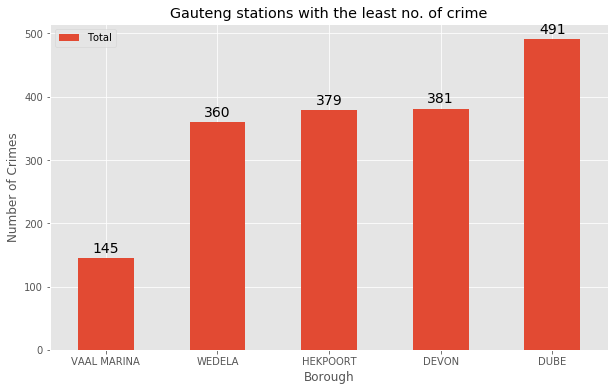

In [117]:
df_bt = df_bot5[['Station','Total']]

df_bt.set_index('Station',inplace = True)

ax = df_bt.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Borough') # add y-label to the plot
ax.set_title('Gauteng stations with the least no. of crime') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

Quick look at the Vaal Marina area, as it has the lowest reported crime stats in Gauteng.

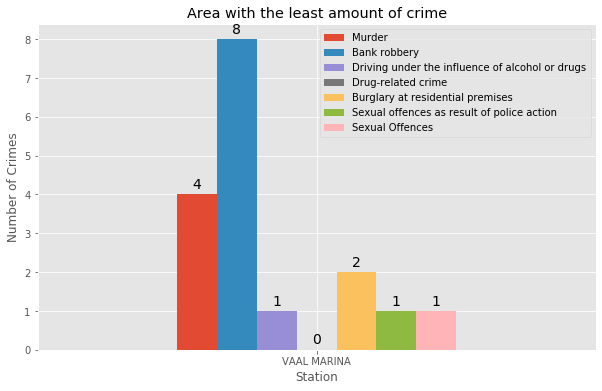

In [199]:
df_bc1 =  df_bot5[df_bot5['Station'] == 'VAAL MARINA']

df_bc = df_bc1[['Station','Murder', 'Bank robbery',
      'Driving under the influence of alcohol or drugs',
       'Drug-related crime',
       'Burglary at residential premises',
       'Sexual offences as result of police action','Sexual Offences']]


df_bc.set_index('Station',inplace = True)

ax = df_bc.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Station') # add y-label to the plot
ax.set_title('Area with the least amount of crime') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

## Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

Let's explore first station in our data set

In [122]:
Gauteng.loc[0, 'Station']

'ACTONVILLE'

In [124]:
station_latitude = Gauteng.loc[0, 'Latitude'] # neighborhood latitude value
station_longitude = Gauteng.loc[0, 'Longitude'] # neighborhood longitude value

station_name = Gauteng.loc[0, 'Station'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(station_name, 
                                                               station_latitude, 
                                                               station_longitude))

Latitude and longitude values of ACTONVILLE are -26.21198, 28.29975.


Now, let's get the top 100 venues that are in Actonville within a radius of 500 meters.

First, let's create the GET request URL. Name your URL url.

In [125]:
LIMIT = 100
radius = 500

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    station_latitude, 
    station_longitude, 
    radius, 
    LIMIT)
url 

'https://api.foursquare.com/v2/venues/explore?&client_id=R01LINGO2WC45KLRLKT3ZHU2QENAO2IPRK2N2ELOHRNK4P3K&client_secret=4JT1TWRMXMPLX5IOKNBAFU3L3ARXK4D5JJDPFK1CLRZM2ZVW&v=20180604&ll=-26.21198,28.29975&radius=500&limit=100'

In [126]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e594b28b57e88001b277ad6'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Boksburg North',
  'headerFullLocation': 'Boksburg North',
  'headerLocationGranularity': 'city',
  'totalResults': 3,
  'suggestedBounds': {'ne': {'lat': -26.207479995499995,
    'lng': 28.304756433925743},
   'sw': {'lat': -26.216480004500006, 'lng': 28.294743566074256}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c3b31fe1a1cd13a61ecb50d',
       'name': 'Beras Supermarket',
       'location': {'address': 'Pillay Street',
        'lat': -26.214618318048515,
        'lng': 28.30126464790425,
        'labeledLatLngs': [{'label': '

Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [127]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [128]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Beras Supermarket,Food & Drink Shop,-26.214618,28.301265
1,uzmas,Indian Restaurant,-26.215078,28.298085
2,Tux Watch Repairs,Shop & Service,-26.215100,28.298060


And how many venues were returned by Foursquare?

In [129]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

3 venues were returned by Foursquare.


**Let's create a function to repeat the same process to all the Stations in Gauteng**

In [131]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [134]:
gauteng_venues = getNearbyVenues(names=Gauteng['Station'],
                                   latitudes=Gauteng['Latitude'],
                                   longitudes=Gauteng['Longitude']
                                  )

VAAL MARINA
WEDELA
HEKPOORT
DEVON
DUBE
DUNNOTTAR
THE BARRAGE
MAGALIESBURG
TARLTON
KLIPRIVIER
ZONKIZIZWE
BOIPATONG
WELBEKEND
LAUDIUM
CRYSTALPARK
KAMEELDRIFT
RATANDA
ERASMIA
FAIRLAND
EERSTERUST
EKANGALA
ROSEBANK
WONDERBOOMPOORT
ACTONVILLE
PUTFONTEIN
NIGEL
MULDERSDRIFT
BOSCHKOP
FOCHVILLE
SEBENZA
KHUTSONG
HEIDELBERG (GP)
OR TAMBO INTERN AIRP
SHARPEVILLE
BEKKERSDAL
PRETORIA MOOT
OLIFANTSFONTEIN
TOKOZA
SANDRINGHAM
DUDUZA
CULLINAN
EDENPARK
MEYERTON
WESTONARIA
LANGLAAGTE
KATLEHONG NORTH
DAWN PARK
NALEDI
DE DEUR
REIGERPARK
LENASIA SOUTH
ELSBURG
BRACKENDOWNS
ETWATWA
TEMBISA SOUTH
PRIMROSE
MAMELODI
NORWOOD
HAMMANSKRAAL
PARKVIEW
MABOPANE
ENNERDALE
DAVEYTON
VILLIERIA
EDENVALE
GA-RANKUWA
RABIE RIDGE
BEDFORDVIEW
SINOVILLE
CLEVELAND
KWA THEMA
BOKSBURG
PRETORIA NORTH
LOATE
BRONKHORSTSPRUIT
HERCULES
CARLETONVILLE
OLIEVENHOUTBOSCH
GARSFONTEIN
BRAMLEY
SILVERTON
DIEPSLOOT
SEBOKENG
NORKEMPARK
YEOVILLE
LENASIA
KATLEHONG
MOFFATVIEW
VOSLOORUS
SOSHANGUVE
BRAKPAN
JABULANI
DIEPKLOOF
MAMELODI EAST
BRIXTON
PROTEA G

In [135]:
print(gauteng_venues.shape)
gauteng_venues.head()

(520, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,MAGALIESBURG,-25.99744,27.53867,The Goods Shed,-26.001436,27.539208,Arts & Crafts Store
1,MAGALIESBURG,-25.99744,27.53867,Magaliesburg Reefsteamers Station,-26.001674,27.537767,Platform
2,KLIPRIVIER,-26.42027,28.08452,Saverite emakhazeni-Belfast,-26.421026,28.079876,Convenience Store
3,KLIPRIVIER,-26.42027,28.08452,Wimpy,-26.421026,28.079876,Burger Joint
4,CRYSTALPARK,-26.12412,28.37297,Engen Crystal Park Filling Station,-26.124411,28.371475,Gas Station


In [138]:
gauteng_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
ACTONVILLE,3,3,3,3,3,3
AKASIA,1,1,1,1,1,1
ALBERTON,3,3,3,3,3,3
ALEXANDRA,5,5,5,5,5,5
ATTERIDGEVILLE,1,1,1,1,1,1
...,...,...,...,...,...,...
VILLIERIA,1,1,1,1,1,1
VOSLOORUS,2,2,2,2,2,2
WESTONARIA,2,2,2,2,2,2


In [140]:
print('There are {} uniques categories.'.format(len(gauteng_venues['Venue Category'].unique())))

There are 135 uniques categories.


## Analyze Each Station/Area

In [141]:
# one hot encoding
gauteng_onehot = pd.get_dummies(gauteng_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
gauteng_onehot['Neighborhood'] = gauteng_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [gauteng_onehot.columns[-1]] + list(gauteng_onehot.columns[:-1])
gauteng_onehot = gauteng_onehot[fixed_columns]

gauteng_onehot.head()

,Neighborhood,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,Arcade,Argentinian Restaurant,...,Supermarket,Sushi Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Train Station,Video Store,Whisky Bar,Yoga Studio
0,MAGALIESBURG,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,MAGALIESBURG,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,KLIPRIVIER,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,KLIPRIVIER,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CRYSTALPARK,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [142]:
gauteng_onehot.shape

(520, 136)

Next, let's group rows by area/neighborhood and by taking the mean of the frequency of occurrence of each category

In [143]:
gauteng_grouped = gauteng_onehot.groupby('Neighborhood').mean().reset_index()
gauteng_grouped

,Neighborhood,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,Arcade,Argentinian Restaurant,...,Supermarket,Sushi Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Train Station,Video Store,Whisky Bar,Yoga Studio
0,ACTONVILLE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AKASIA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ALBERTON,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ALEXANDRA,0.0,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ATTERIDGEVILLE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,VILLIERIA,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,VOSLOORUS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,WESTONARIA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99,WONDERBOOMPOORT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [144]:
gauteng_grouped.shape

(101, 136)

#### Let's print each neighborhood along with the top 5 most common venues

In [156]:
num_top_venues = 5

for hood in gauteng_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = gauteng_grouped[gauteng_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ACTONVILLE----
               venue  freq
0     Shop & Service  0.33
1  Food & Drink Shop  0.33
2  Indian Restaurant  0.33
3     Adult Boutique  0.00
4          Multiplex  0.00


----AKASIA----
                       venue  freq
0                Gas Station   1.0
1             Adult Boutique   0.0
2                Music Venue   0.0
3  Middle Eastern Restaurant   0.0
4         Miscellaneous Shop   0.0


----ALBERTON----
                venue  freq
0           BBQ Joint  0.33
1   Electronics Store  0.33
2        Burger Joint  0.33
3      Adult Boutique  0.00
4  Mexican Restaurant  0.00


----ALEXANDRA----
                      venue  freq
0                   Butcher   0.2
1        African Restaurant   0.2
2         Afghan Restaurant   0.2
3      Fast Food Restaurant   0.2
4  Bike Rental / Bike Share   0.2


----ATTERIDGEVILLE----
                       venue  freq
0             Soccer Stadium   1.0
1             Adult Boutique   0.0
2                Music Venue   0.0
3  Middle Easter

Let's put that into a pandas dataframe.

First, let's write a function to sort the venues in **descending order.**

In [157]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [212]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = gauteng_grouped['Neighborhood']

for ind in np.arange(gauteng_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(gauteng_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ACTONVILLE,Shop & Service,Food & Drink Shop,Indian Restaurant,Dessert Shop,Electronics Store,Eastern European Restaurant,Duty-free Shop,Donut Shop,Diner,Yoga Studio
1,AKASIA,Gas Station,Yoga Studio,Dessert Shop,Electronics Store,Eastern European Restaurant,Duty-free Shop,Donut Shop,Diner,Department Store,Farm
2,ALBERTON,Burger Joint,BBQ Joint,Electronics Store,Yoga Studio,Eastern European Restaurant,Duty-free Shop,Donut Shop,Diner,Dessert Shop,Farm
3,ALEXANDRA,Butcher,African Restaurant,Bike Rental / Bike Share,Fast Food Restaurant,Afghan Restaurant,Convenience Store,Cosmetics Shop,Dance Studio,Deli / Bodega,Department Store
4,ATTERIDGEVILLE,Soccer Stadium,Yoga Studio,Dessert Shop,Electronics Store,Eastern European Restaurant,Duty-free Shop,Donut Shop,Diner,Department Store,Farm


## Cluster Neighborhoods

Run k-means to cluster the neighborhood into 5 clusters.

In [213]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 5

gauteng_grouped_clustering = gauteng_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(gauteng_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 2, 0, 0, 1, 0, 4, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [214]:
#just changing col from station to neighborhood so that we can join tables
Gauteng1 =Gauteng.rename(columns={'Station': 'Neighborhood'})
Gauteng1.head()

,Neighborhood,Longitude,Latitude,All theft not mentioned elsewhere,Commercial crime,Robbery with aggravating circumstances,Theft out of or from motor vehicle,Assault with the intent to inflict grievous bodily harm,Burglary at residential premises,Common assault,...,Attempted murder,Illegal possession of firearms and ammunition,Murder,Arson,Stock-theft,Truck hijacking,Robbery of cash in transit,Bank robbery,Sexual offences as result of police action,Total
131,VAAL MARINA,28.23124,-26.87308,31,2,15,1,0,2,35,...,0,5,4,0,0,3,4,8,1,145
136,WEDELA,27.38300,-26.45670,32,1,62,5,0,11,73,...,0,23,17,0,0,3,3,4,0,360
52,HEKPOORT,27.61817,-25.89610,123,3,27,9,0,4,75,...,0,17,3,0,0,14,3,6,0,379
26,DEVON,28.78603,-26.35630,47,4,39,5,0,38,36,...,0,24,14,0,0,17,9,16,1,381
31,DUBE,28.02384,-25.40502,38,2,79,17,0,27,68,...,0,61,11,0,0,14,6,10,1,491


In [215]:
# add clustering labels
neighborhoods_venues_sorted.insert(1, "Cluster Labels", kmeans.labels_)


gauteng_merged= pd.merge(neighborhoods_venues_sorted, Gauteng1, on='Neighborhood')

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
#gauteng_merged = gauteng_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

gauteng_merged.head() # check the last columns!

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,...,Attempted murder,Illegal possession of firearms and ammunition,Murder,Arson,Stock-theft,Truck hijacking,Robbery of cash in transit,Bank robbery,Sexual offences as result of police action,Total
0,ACTONVILLE,0,Shop & Service,Food & Drink Shop,Indian Restaurant,Dessert Shop,Electronics Store,Eastern European Restaurant,Duty-free Shop,Donut Shop,...,1,126,31,2,47,0,64,69,0,1583
1,AKASIA,0,Gas Station,Yoga Studio,Dessert Shop,Electronics Store,Eastern European Restaurant,Duty-free Shop,Donut Shop,Diner,...,0,620,124,1,268,5,319,373,0,6828
2,ALBERTON,0,Burger Joint,BBQ Joint,Electronics Store,Yoga Studio,Eastern European Restaurant,Duty-free Shop,Donut Shop,Diner,...,2,457,60,3,287,0,478,363,26,5721
3,ALEXANDRA,2,Butcher,African Restaurant,Bike Rental / Bike Share,Fast Food Restaurant,Afghan Restaurant,Convenience Store,Cosmetics Shop,Dance Studio,...,1,649,179,2,169,0,148,188,1,6326
4,ATTERIDGEVILLE,0,Soccer Stadium,Yoga Studio,Dessert Shop,Electronics Store,Eastern European Restaurant,Duty-free Shop,Donut Shop,Diner,...,0,616,117,0,203,0,92,336,8,6888


Finally, let's visualize the resulting clusters.

In [216]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(gauteng_merged['Latitude'], gauteng_merged['Longitude'], gauteng_merged['Neighborhood'], gauteng_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Examine Clusters

Now we can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. 

## Cluster 1

In [217]:
cluster1 = gauteng_merged[gauteng_merged['Cluster Labels'] == 0]
cluster1

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,...,Attempted murder,Illegal possession of firearms and ammunition,Murder,Arson,Stock-theft,Truck hijacking,Robbery of cash in transit,Bank robbery,Sexual offences as result of police action,Total
0,ACTONVILLE,0,Shop & Service,Food & Drink Shop,Indian Restaurant,Dessert Shop,Electronics Store,Eastern European Restaurant,Duty-free Shop,Donut Shop,...,1,126,31,2,47,0,64,69,0,1583
1,AKASIA,0,Gas Station,Yoga Studio,Dessert Shop,Electronics Store,Eastern European Restaurant,Duty-free Shop,Donut Shop,Diner,...,0,620,124,1,268,5,319,373,0,6828
2,ALBERTON,0,Burger Joint,BBQ Joint,Electronics Store,Yoga Studio,Eastern European Restaurant,Duty-free Shop,Donut Shop,Diner,...,2,457,60,3,287,0,478,363,26,5721
4,ATTERIDGEVILLE,0,Soccer Stadium,Yoga Studio,Dessert Shop,Electronics Store,Eastern European Restaurant,Duty-free Shop,Donut Shop,Diner,...,0,616,117,0,203,0,92,336,8,6888
5,BEDFORDVIEW,0,Shopping Mall,Seafood Restaurant,Pizza Place,Steakhouse,Grocery Store,Burger Joint,Italian Restaurant,Asian Restaurant,...,0,344,16,1,399,0,243,296,28,3622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,SUNNYSIDE,0,Pizza Place,Gas Station,Nightclub,Burger Joint,Duty-free Shop,Donut Shop,Diner,Dessert Shop,...,0,710,63,10,338,0,424,1614,2,9113
89,TEMBA,0,Pub,Yoga Studio,Department Store,Electronics Store,Eastern European Restaurant,Duty-free Shop,Donut Shop,Diner,...,0,863,211,0,150,48,196,267,3,9708
96,VILLIERIA,0,African Restaurant,Yoga Studio,Department Store,Electronics Store,Eastern European Restaurant,Duty-free Shop,Donut Shop,Diner,...,0,179,28,1,75,0,289,371,5,3515
98,WESTONARIA,0,Pharmacy,Astrologer,Farm,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Duty-free Shop,Donut Shop,...,0,211,51,0,124,21,114,123,7,2526


Have a look at the 5 safest cities in this cluster

In [218]:
cluster1.sort_values(['Total'], ascending = True, axis = 0, inplace = True )

cl1_bot5 = cluster1.head() 
cl1_bot5

/Users/lukabeverin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,...,Attempted murder,Illegal possession of firearms and ammunition,Murder,Arson,Stock-theft,Truck hijacking,Robbery of cash in transit,Bank robbery,Sexual offences as result of police action,Total
56,MAGALIESBURG,0,Platform,Arts & Crafts Store,Yoga Studio,Dessert Shop,Electronics Store,Eastern European Restaurant,Duty-free Shop,Donut Shop,...,0,26,10,0,10,16,6,23,3,708
18,CRYSTALPARK,0,Gas Station,Yoga Studio,Dessert Shop,Electronics Store,Eastern European Restaurant,Duty-free Shop,Donut Shop,Diner,...,0,126,41,1,5,1,38,60,0,1223
32,FAIRLAND,0,Performing Arts Venue,Chinese Restaurant,Restaurant,Jewelry Store,Dessert Shop,Eastern European Restaurant,Duty-free Shop,Donut Shop,...,0,100,7,2,33,0,115,241,0,1395
26,EERSTERUST,0,Liquor Store,Yoga Studio,Dessert Shop,Electronics Store,Eastern European Restaurant,Duty-free Shop,Donut Shop,Diner,...,0,39,10,0,12,0,17,92,0,1505
27,EKANGALA,0,Bakery,Dessert Shop,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Duty-free Shop,Donut Shop,Diner,...,0,123,34,0,11,6,36,35,2,1511


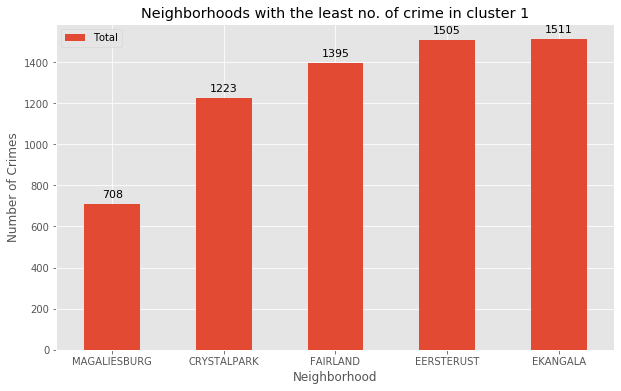

In [225]:
cl1_bt = cl1_bot5[['Neighborhood','Total']]

cl1_bt.set_index('Neighborhood',inplace = True)

ax = cl1_bt.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Neighborhood') # add y-label to the plot
ax.set_title('Neighborhoods with the least no. of crime in cluster 1') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 11
               )

plt.show()

# Cluster 2

In [233]:
cluster2 = gauteng_merged[gauteng_merged['Cluster Labels'] == 1]
cluster2

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,...,Attempted murder,Illegal possession of firearms and ammunition,Murder,Arson,Stock-theft,Truck hijacking,Robbery of cash in transit,Bank robbery,Sexual offences as result of police action,Total
6,BEKKERSDAL,1,Convenience Store,Yoga Studio,Farm,Concert Hall,Construction & Landscaping,Cosmetics Shop,Dance Studio,Deli / Bodega,...,0,247,86,1,1,5,63,44,13,2253
30,ERASMIA,1,Flea Market,Convenience Store,Yoga Studio,Dessert Shop,Electronics Store,Eastern European Restaurant,Duty-free Shop,Donut Shop,...,0,140,25,1,1,1,24,52,1,1363
31,ETWATWA,1,Convenience Store,Yoga Studio,Farm,Concert Hall,Construction & Landscaping,Cosmetics Shop,Dance Studio,Deli / Bodega,...,1,246,100,0,0,0,90,39,1,2871
49,KLIPRIVIER,1,Burger Joint,Convenience Store,Yoga Studio,Electronics Store,Eastern European Restaurant,Duty-free Shop,Donut Shop,Diner,...,0,76,13,0,5,14,17,69,9,803
90,TEMBISA,1,Pizza Place,Convenience Store,Department Store,Electronics Store,Eastern European Restaurant,Duty-free Shop,Donut Shop,Diner,...,0,694,192,1,129,0,220,384,2,7758
92,TOKOZA,1,Convenience Store,Gas Station,Yoga Studio,Dessert Shop,Electronics Store,Eastern European Restaurant,Duty-free Shop,Donut Shop,...,1,153,69,1,79,0,85,63,0,2420


In [234]:
cluster2.sort_values(['Total'], ascending = True, axis = 0, inplace = True )

cl2_bot5 = cluster2.head() 
cl2_bot5

/Users/lukabeverin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,...,Attempted murder,Illegal possession of firearms and ammunition,Murder,Arson,Stock-theft,Truck hijacking,Robbery of cash in transit,Bank robbery,Sexual offences as result of police action,Total
49,KLIPRIVIER,1,Burger Joint,Convenience Store,Yoga Studio,Electronics Store,Eastern European Restaurant,Duty-free Shop,Donut Shop,Diner,...,0,76,13,0,5,14,17,69,9,803
30,ERASMIA,1,Flea Market,Convenience Store,Yoga Studio,Dessert Shop,Electronics Store,Eastern European Restaurant,Duty-free Shop,Donut Shop,...,0,140,25,1,1,1,24,52,1,1363
6,BEKKERSDAL,1,Convenience Store,Yoga Studio,Farm,Concert Hall,Construction & Landscaping,Cosmetics Shop,Dance Studio,Deli / Bodega,...,0,247,86,1,1,5,63,44,13,2253
92,TOKOZA,1,Convenience Store,Gas Station,Yoga Studio,Dessert Shop,Electronics Store,Eastern European Restaurant,Duty-free Shop,Donut Shop,...,1,153,69,1,79,0,85,63,0,2420
31,ETWATWA,1,Convenience Store,Yoga Studio,Farm,Concert Hall,Construction & Landscaping,Cosmetics Shop,Dance Studio,Deli / Bodega,...,1,246,100,0,0,0,90,39,1,2871


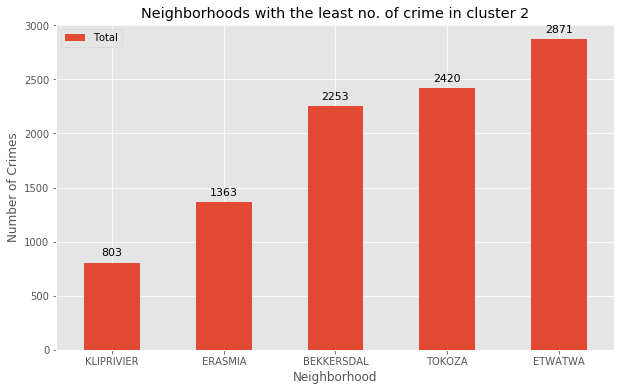

In [235]:
cl2_bt = cl2_bot5[['Neighborhood','Total']]

cl2_bt.set_index('Neighborhood',inplace = True)

ax = cl2_bt.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Neighborhood') # add y-label to the plot
ax.set_title('Neighborhoods with the least no. of crime in cluster 2') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 11
               )

plt.show()

# Cluster 3

In [236]:
cluster3 = gauteng_merged[gauteng_merged['Cluster Labels'] == 2]
cluster3

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,...,Attempted murder,Illegal possession of firearms and ammunition,Murder,Arson,Stock-theft,Truck hijacking,Robbery of cash in transit,Bank robbery,Sexual offences as result of police action,Total
3,ALEXANDRA,2,Butcher,African Restaurant,Bike Rental / Bike Share,Fast Food Restaurant,Afghan Restaurant,Convenience Store,Cosmetics Shop,Dance Studio,...,1,649,179,2,169,0,148,188,1,6326
12,BRAMLEY,2,Fast Food Restaurant,Sporting Goods Shop,Dessert Shop,Electronics Store,Eastern European Restaurant,Duty-free Shop,Donut Shop,Diner,...,0,433,40,27,21,0,168,231,3,4266
14,BRONKHORSTSPRUIT,2,Fast Food Restaurant,Gas Station,Grocery Store,Restaurant,Yoga Studio,Duty-free Shop,Donut Shop,Diner,...,0,299,60,1,80,54,140,248,15,3935
16,CARLETONVILLE,2,Burger Joint,Fast Food Restaurant,Clothing Store,Convenience Store,Breakfast Spot,Yoga Studio,Eastern European Restaurant,Duty-free Shop,...,0,286,69,2,185,31,152,138,2,4066
17,CLEVELAND,2,Fast Food Restaurant,Spa,Dessert Shop,Electronics Store,Eastern European Restaurant,Duty-free Shop,Donut Shop,Diner,...,0,437,52,1,88,0,188,236,5,3750
20,DAVEYTON,2,Shopping Mall,Clothing Store,Grocery Store,Fast Food Restaurant,Dessert Shop,Electronics Store,Eastern European Restaurant,Duty-free Shop,...,1,283,93,0,225,1,76,81,1,3497
22,DIEPKLOOF,2,Restaurant,Yoga Studio,Dessert Shop,Electronics Store,Eastern European Restaurant,Duty-free Shop,Donut Shop,Diner,...,0,234,77,0,442,0,119,198,2,5327
33,FLORIDA,2,Pharmacy,Fast Food Restaurant,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,...,1,505,55,5,137,0,453,610,14,6870
34,FOCHVILLE,2,Fast Food Restaurant,Lawyer,Restaurant,Yoga Studio,Ethiopian Restaurant,Eastern European Restaurant,Duty-free Shop,Donut Shop,...,0,91,45,0,12,68,64,48,4,1801
39,HERCULES,2,Pizza Place,Fast Food Restaurant,Burger Joint,Pharmacy,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,...,0,191,74,11,64,7,248,171,2,4036


In [249]:
cluster3.sort_values(['Total'], ascending = True, axis = 0, inplace = True )
cl3_bot5 = cluster3.head() 
cl3_bot5

/Users/lukabeverin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,...,Attempted murder,Illegal possession of firearms and ammunition,Murder,Arson,Stock-theft,Truck hijacking,Robbery of cash in transit,Bank robbery,Sexual offences as result of police action,Total
34,FOCHVILLE,2,Fast Food Restaurant,Lawyer,Restaurant,Yoga Studio,Ethiopian Restaurant,Eastern European Restaurant,Duty-free Shop,Donut Shop,...,0,91,45,0,12,68,64,48,4,1801
47,KATLEHONG NORTH,2,Fast Food Restaurant,African Restaurant,Restaurant,Pub,Yoga Studio,Department Store,Duty-free Shop,Donut Shop,...,0,144,78,0,75,3,101,91,1,2572
20,DAVEYTON,2,Shopping Mall,Clothing Store,Grocery Store,Fast Food Restaurant,Dessert Shop,Electronics Store,Eastern European Restaurant,Duty-free Shop,...,1,283,93,0,225,1,76,81,1,3497
17,CLEVELAND,2,Fast Food Restaurant,Spa,Dessert Shop,Electronics Store,Eastern European Restaurant,Duty-free Shop,Donut Shop,Diner,...,0,437,52,1,88,0,188,236,5,3750
55,LOATE,2,Fast Food Restaurant,Farm,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Deli / Bodega,...,0,373,108,0,469,7,43,52,1,3928


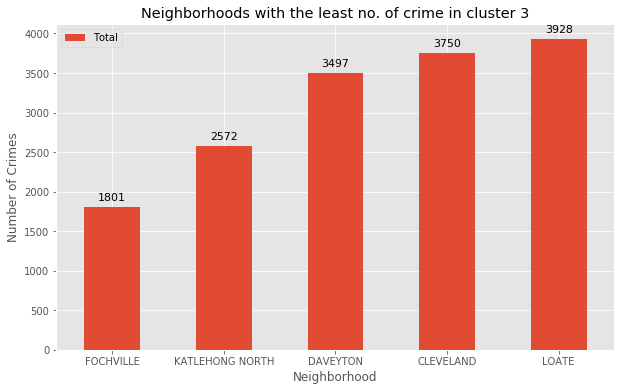

In [238]:
cl3_bt = cl3_bot5[['Neighborhood','Total']]

cl3_bt.set_index('Neighborhood',inplace = True)

ax = cl3_bt.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Neighborhood') # add y-label to the plot
ax.set_title('Neighborhoods with the least no. of crime in cluster 3') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 11
               )

plt.show()

# Cluster 4 

In [240]:
cluster4 = gauteng_merged[gauteng_merged['Cluster Labels'] == 3]
cluster4

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,...,Attempted murder,Illegal possession of firearms and ammunition,Murder,Arson,Stock-theft,Truck hijacking,Robbery of cash in transit,Bank robbery,Sexual offences as result of police action,Total
60,MOFFATVIEW,3,Other Repair Shop,Yoga Studio,Department Store,Electronics Store,Eastern European Restaurant,Duty-free Shop,Donut Shop,Diner,...,0,440,47,1,213,0,340,317,4,5002
65,NIGEL,3,Other Repair Shop,Yoga Studio,Department Store,Electronics Store,Eastern European Restaurant,Duty-free Shop,Donut Shop,Diner,...,0,86,32,0,46,27,42,67,4,1658
91,TEMBISA SOUTH,3,Bar,Other Repair Shop,Dessert Shop,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Duty-free Shop,Donut Shop,...,0,281,62,0,116,0,77,220,0,2919


In [243]:
cluster4.sort_values(['Total'], ascending = True, axis = 0, inplace = True )
cl4_bot5 = cluster4.head() 
cl4_bot5

/Users/lukabeverin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,...,Attempted murder,Illegal possession of firearms and ammunition,Murder,Arson,Stock-theft,Truck hijacking,Robbery of cash in transit,Bank robbery,Sexual offences as result of police action,Total
65,NIGEL,3,Other Repair Shop,Yoga Studio,Department Store,Electronics Store,Eastern European Restaurant,Duty-free Shop,Donut Shop,Diner,...,0,86,32,0,46,27,42,67,4,1658
91,TEMBISA SOUTH,3,Bar,Other Repair Shop,Dessert Shop,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Duty-free Shop,Donut Shop,...,0,281,62,0,116,0,77,220,0,2919
60,MOFFATVIEW,3,Other Repair Shop,Yoga Studio,Department Store,Electronics Store,Eastern European Restaurant,Duty-free Shop,Donut Shop,Diner,...,0,440,47,1,213,0,340,317,4,5002


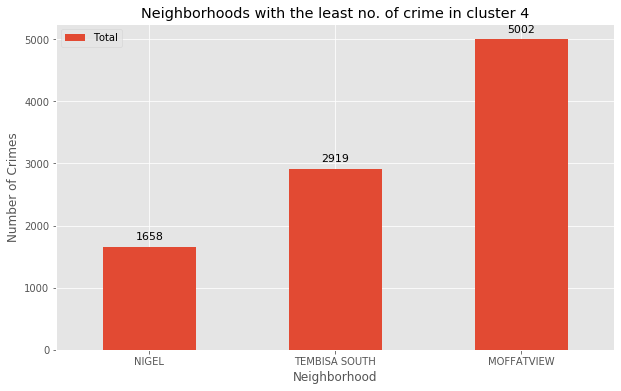

In [244]:
cl4_bt = cl4_bot5[['Neighborhood','Total']]

cl4_bt.set_index('Neighborhood',inplace = True)

ax = cl4_bt.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Neighborhood') # add y-label to the plot
ax.set_title('Neighborhoods with the least no. of crime in cluster 4') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 11
               )

plt.show()

# Cluster 5

In [245]:
cluster5 = gauteng_merged[gauteng_merged['Cluster Labels'] == 4]
cluster5

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,...,Attempted murder,Illegal possession of firearms and ammunition,Murder,Arson,Stock-theft,Truck hijacking,Robbery of cash in transit,Bank robbery,Sexual offences as result of police action,Total
8,BOKSBURG,4,Coffee Shop,Dessert Shop,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Duty-free Shop,Donut Shop,Diner,...,0,353,53,3,38,0,336,338,1,3875
25,EDENVALE,4,Café,Coffee Shop,Yoga Studio,Dessert Shop,Electronics Store,Eastern European Restaurant,Duty-free Shop,Donut Shop,...,0,236,17,0,173,0,299,381,2,3521
63,MULDERSDRIFT,4,Coffee Shop,Dessert Shop,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Duty-free Shop,Donut Shop,Diner,...,0,175,25,1,61,6,53,96,2,1678


In [246]:
cluster5.sort_values(['Total'], ascending = True, axis = 0, inplace = True )
cl5_bot5 = cluster5.head() 
cl5_bot5

/Users/lukabeverin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,...,Attempted murder,Illegal possession of firearms and ammunition,Murder,Arson,Stock-theft,Truck hijacking,Robbery of cash in transit,Bank robbery,Sexual offences as result of police action,Total
63,MULDERSDRIFT,4,Coffee Shop,Dessert Shop,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Duty-free Shop,Donut Shop,Diner,...,0,175,25,1,61,6,53,96,2,1678
25,EDENVALE,4,Café,Coffee Shop,Yoga Studio,Dessert Shop,Electronics Store,Eastern European Restaurant,Duty-free Shop,Donut Shop,...,0,236,17,0,173,0,299,381,2,3521
8,BOKSBURG,4,Coffee Shop,Dessert Shop,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Duty-free Shop,Donut Shop,Diner,...,0,353,53,3,38,0,336,338,1,3875


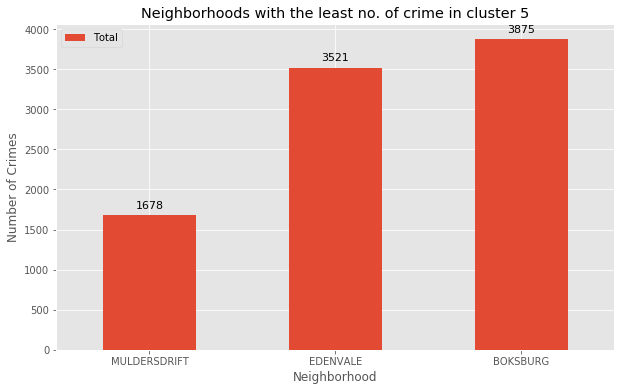

In [247]:
cl5_bt = cl5_bot5[['Neighborhood','Total']]

cl5_bt.set_index('Neighborhood',inplace = True)

ax = cl5_bt.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Neighborhood') # add y-label to the plot
ax.set_title('Neighborhoods with the least no. of crime in cluster 5') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 11
               )

plt.show()

**Notebook completed by Luka Beverin**